#### Version history
* V1 - train with all data for 10000 iterations / step LR scheduling at 5000 and 8000
* V2 - train with all data for 15000 iterations / LR 0.001 / step LR at 10000 / batch_size_per_image 128 -> 512
* V5 - train with all data for 15000 iterations / with Data Augmentation
* V6 - mask_rcnn_R_101_FPN_3x for 20000 iterations / no Data Aug

## Training

All the heavy lifting here is done by the [detectron](https://github.com/facebookresearch/detectron2) library. What's needed from us is pointing it to the annotation files of our dataset (see [part one](https://www.kaggle.com/slawekbiel/positive-score-with-detectron-1-3-input-data/) for details), setting some hyperparameters and calling `trainer.train()`

Most of the code here is just for displaying things to make sure everything is set up correctly and the training worked.

In [4]:
!python -m pip install pyyaml==5.1
import sys, os, distutils.core
# Примечание: это более быстрый способ установки detector2 в Colab, но он не включает все функции (например, скомпилированные операторы).
# См. https://detectron2.readthedocs.io/tutorials/install.html для полных инструкций по установке
# !git clone https://github.com/facebookresearch/detectron2.git
dist = distutils.core.run_setup("./detectron2/setup.py")
!python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}
sys.path.insert(0, os.path.abspath('./detectron2'))

  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [37 lines of output]
      Traceback (most recent call last):
        File "<string>", line 2, in <module>
        File "<pip-setuptools-caller>", line 34, in <module>
        File "C:\Users\1003s\AppData\Local\Temp\pip-install-mdqn8r21\pyyaml_47ee56987e2a4c239376679df41fd4ea\setup.py", line 291, in <module>
          setup(
        File "c:\Users\1003s\anaconda3\envs\main\Lib\site-packages\setuptools\_distutils\core.py", line 184, in setup
          return run_commands(dist)
                 ^^^^^^^^^^^^^^^^^^
        File "c:\Users\1003s\anaconda3\envs\main\Lib\site-packages\setuptools\_distutils\core.py", line 200, in run_commands
          dist.run_commands()
        File "c:\Users\1003s\anaconda3\envs\main\Lib\site-packages\setuptools\_distutils\dist.py", line 970, in run_commands
          self.run_command(cmd)
        File "c:\Users\1003s\anaconda3\envs\main\Lib

  Using cached PyYAML-5.1.tar.gz (274 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'error'


�� 㤠���� ���� 㪠����� 䠩�.


In [5]:
import copy
import detectron2
from pathlib import Path
import random, cv2, os
import matplotlib.pyplot as plt
import numpy as np
import pycocotools.mask as maskUtils
import torch
from tqdm import tqdm

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor, DefaultTrainer
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer, ColorMode
from detectron2.data import MetadataCatalog, DatasetCatalog, DatasetMapper, build_detection_train_loader
from detectron2.data import detection_utils as utils
import detectron2.data.transforms as T
from detectron2.data.datasets import register_coco_instances
from detectron2.utils.logger import setup_logger
from detectron2.evaluation.evaluator import DatasetEvaluator
from pycocotools.coco import COCO
import json
setup_logger()
plt.set_loglevel("warning")

matplotlib data path: c:\Users\1003s\anaconda3\envs\main\Lib\site-packages\matplotlib\mpl-data
CONFIGDIR=C:\Users\1003s\.matplotlib
interactive is False
platform is win32
CACHEDIR=C:\Users\1003s\.matplotlib
Using fontManager instance from C:\Users\1003s\.matplotlib\fontlist-v390.json


In [6]:
# Зафиксируем сиды, чтобы обучение было воспроизводимым.
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(1001)

### Load the competition data
This is very simple once we have our data in the COCO format. See the [part one notebook](https://www.kaggle.com/slawekbiel/positive-score-with-detectron-1-3-input-data/) for details.

In [2]:
class Font:
   GREEN = '\033[92m'
   BOLD = '\033[1m'
   END = '\033[0m'

In [ ]:
annotation_files = [
    "train_annotations.json",
    "val_annotations.json",
]

output_annotation_files = [
    "updated_train_annotations.json",
    "updated_val_annotations.json"
]

for n in range(len(annotation_files)):
    print(f"{Font.GREEN}Processing {annotation_files[n]} ...{Font.END}")

    # Initialize COCO object
    coco = COCO(annotation_files[n])

    print(f"{Font.GREEN}Starting filtering ...{Font.END}")

    for i in tqdm(coco.getAnnIds(coco.getImgIds())):
        # check correct polygon format
        anns = []
        for j in range(len(coco.anns[i]['segmentation'])):
            if len(coco.anns[i]['segmentation'][j]) > 4:
                anns.append(coco.anns[i]['segmentation'][j])

        if anns:
            coco.anns[i]['segmentation'] = anns

            # Convert segmentation to RLE
            rle = coco.annToRLE(coco.anns[i])

            # Update the annotation's segmentation with the RLE
            coco.anns[i]['segmentation'] = {
                "size" : rle["size"],
                "counts" : rle["counts"].decode("utf-8")
            }
        else:
            del coco.anns[i]

    # Update the dataset with the new annotations
    coco.dataset['annotations'] = list(coco.anns.values())

    print(f"{Font.GREEN}Writing to temporary file {output_annotation_files[n]} ...{Font.END}")

    # Save to a new JSON file
    with open(output_annotation_files[n], 'w') as f:
        json.dump(coco.dataset, f)


    print(f"{Font.GREEN}Deleting empty annotations ...{Font.END}")
    
    coco = COCO(output_annotation_files[n])

    for img_id in tqdm(coco.getImgIds()):
        anns_ids = coco.getAnnIds(img_id)

        if not anns_ids:
            del coco.imgs[img_id]

    coco.dataset['images'] = list(coco.imgs.values())


    print(f"{Font.GREEN}Writing to final file {output_annotation_files[n]} ...{Font.END}")

    # Save to a new JSON file
    with open(output_annotation_files[n], 'w') as f:
        json.dump(coco.dataset, f)

    print(f"{Font.GREEN}Done!{Font.END}")

Processing train_annotations.json ...
loading annotations into memory...
Done (t=6.70s)
creating index...
index created!
Starting filtering ...


100%|██████████| 18527/18527 [00:03<00:00, 5995.78it/s]


Writing to final file updated_train_annotations.json ...
Done!
Processing val_annotations.json ...
loading annotations into memory...
Done (t=3.42s)
creating index...
index created!
Starting filtering ...


100%|██████████| 9551/9551 [00:01<00:00, 5452.28it/s]


Writing to final file updated_val_annotations.json ...
Done!


In [8]:
import albumentations as A

train_transform = A.Compose(
    [
        A.OneOf(
            [
                A.Rotate(limit=(-10, 10), p=0.5),
                A.Perspective(fit_output=True, p=0.5),
            ],
            p=0.5
        ),
        A.HorizontalFlip(p=0.5),

        A.OneOf(
            [
                A.ColorJitter(
                    brightness=0.1,
                    contrast=0.1,
                    saturation=0.1,
                    hue=0.1,
                    p=0.8
                ),
                A.ToGray(p=0.2)
            ],
            p=0.6
        ),
        A.CLAHE(clip_limit=2, p=0.3),
        A.MotionBlur(blur_limit=3, p=0.3),
    ]
)

dataset_names = [
    "animal_train"
]

annotation_files = [
    "updated_train_annotations.json"
]

output_annotation_files = [
    "augmented_train_annotations.json"
]

img_dirs = [
    "train"
]

output_dirs = [
    "augmented_train"
]

transforms = [
    train_transform
]

c:\Users\1003s\anaconda3\envs\main\Lib\site-packages\albumentations\__init__.py:24: UserWarning: A new version of Albumentations is available: '2.0.3' (you have '2.0.0'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [6]:
for i in range(len(annotation_files)):
    print(f"{Font.GREEN}Processing {annotation_files[i]} ...{Font.END}")

    coco = COCO(annotation_files[i])

    print(f"{Font.GREEN}Creating directory {output_dirs[i]} ...{Font.END}")

    os.makedirs(output_dirs[i], exist_ok=True)

    print(f"{Font.GREEN}Starting augmenting ...{Font.END}")

    for img_id in tqdm(coco.getImgIds()):
        file_name = coco.imgs[img_id]['file_name']
        anns_ids = coco.getAnnIds(img_id)

        masks = []
        for j in anns_ids:
            masks.append(coco.annToMask(coco.anns[j]))

        image = cv2.imread(f'{img_dirs[i]}/{file_name}')
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        transformed = transforms[i](image=image, masks=masks)

        plt.imsave(f'{output_dirs[i]}/{file_name}', transformed['image'])

        for n, anns_id in enumerate(anns_ids):
            rle = maskUtils.encode(np.asfortranarray(transformed['masks'][n]))
            bbox = list(maskUtils.toBbox(rle))
            area = int(maskUtils.area(rle))

            coco.anns[anns_id]['bbox'] = bbox
            coco.anns[anns_id]['area'] = area
            coco.anns[anns_id]['segmentation'] = {
                "size" : rle["size"],
                "counts" : rle["counts"].decode("utf-8")
            }
                    
     # Update the dataset with the new annotations
    coco.dataset['annotations'] = list(coco.anns.values())

    print(f"{Font.GREEN}Writing to file {output_annotation_files[i]}...{Font.END}")

    # Save to a new JSON file
    with open(output_annotation_files[i], 'w') as f:
        json.dump(coco.dataset, f)

    print(f"{Font.GREEN}Done!{Font.END}")

Processing updated_train_annotations.json ...
loading annotations into memory...
Done (t=0.13s)
creating index...
index created!
Creating directory augmented_train ...
Starting augmenting ...


  0%|          | 54/16631 [00:02<12:02, 22.93it/s]


KeyboardInterrupt: 

In [33]:
cocoCheck = COCO("augmented_train_annotations.json")

loading annotations into memory...
Done (t=0.11s)
creating index...
index created!


In [34]:
img_id = 16631
file_name = cocoCheck.imgs[img_id]['file_name']

In [35]:
anns_ids = cocoCheck.getAnnIds(img_id)
anns = cocoCheck.loadAnns(anns_ids)

In [37]:
masks = []
for i in range(len(anns)):
    masks.append(cocoCheck.annToMask(anns[i]))

In [38]:
image = cv2.imread("train/" + file_name)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

image_transformed = cv2.imread("augmented_train/" + file_name)
image_transformed = cv2.cvtColor(image_transformed, cv2.COLOR_BGR2RGB)

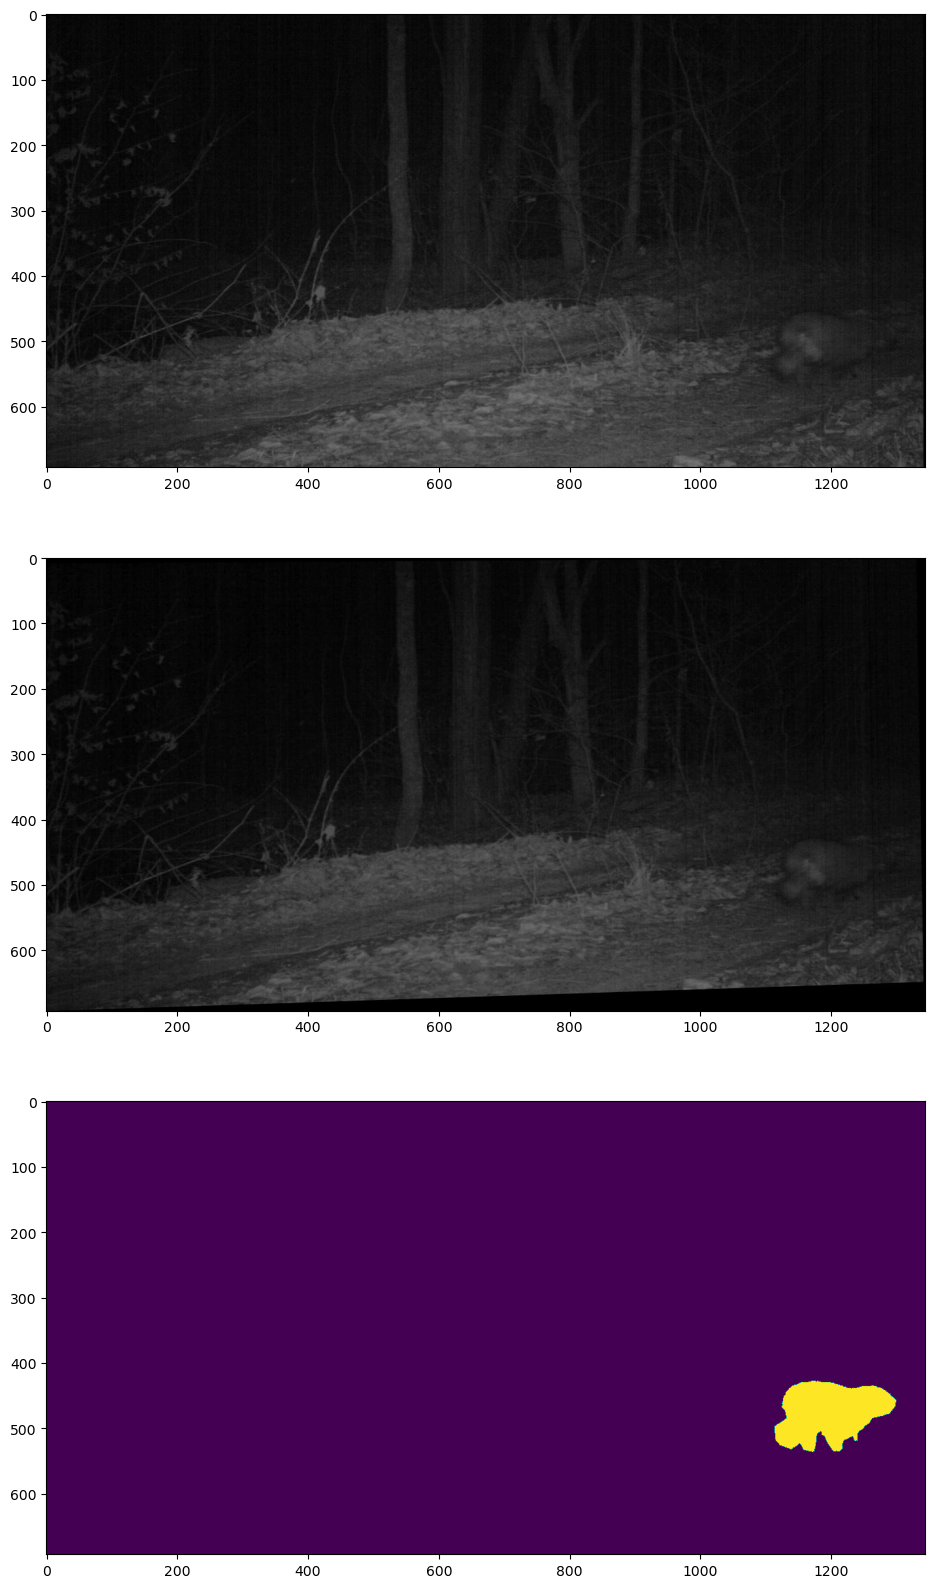

In [39]:
fig, axes = plt.subplots(len(masks) + 2, 1, figsize=(20, 20))
axes = axes.reshape(-1)
axes[0].imshow(image)
axes[1].imshow(image_transformed)
for i in range(2, len(axes)):
    axes[i].imshow(masks[i - 2])

In [6]:
# dataDir=Path('train')
cfg = get_cfg()
cfg.INPUT.MASK_FORMAT='bitmask'
register_coco_instances("animal_train", {}, "augmented_train_annotations.json", "augmented_train")
register_coco_instances("animal_val", {}, "updated_val_annotations.json", "val")
metadata = MetadataCatalog.get('animal_train')
train_ds = DatasetCatalog.get('animal_train')

WARNING [01/30 19:37:20 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[01/30 19:37:20 d2.data.datasets.coco]: Loaded 16631 images in COCO format from augmented_train_annotations.json


### Display a sample file to check the data is loaded correctly

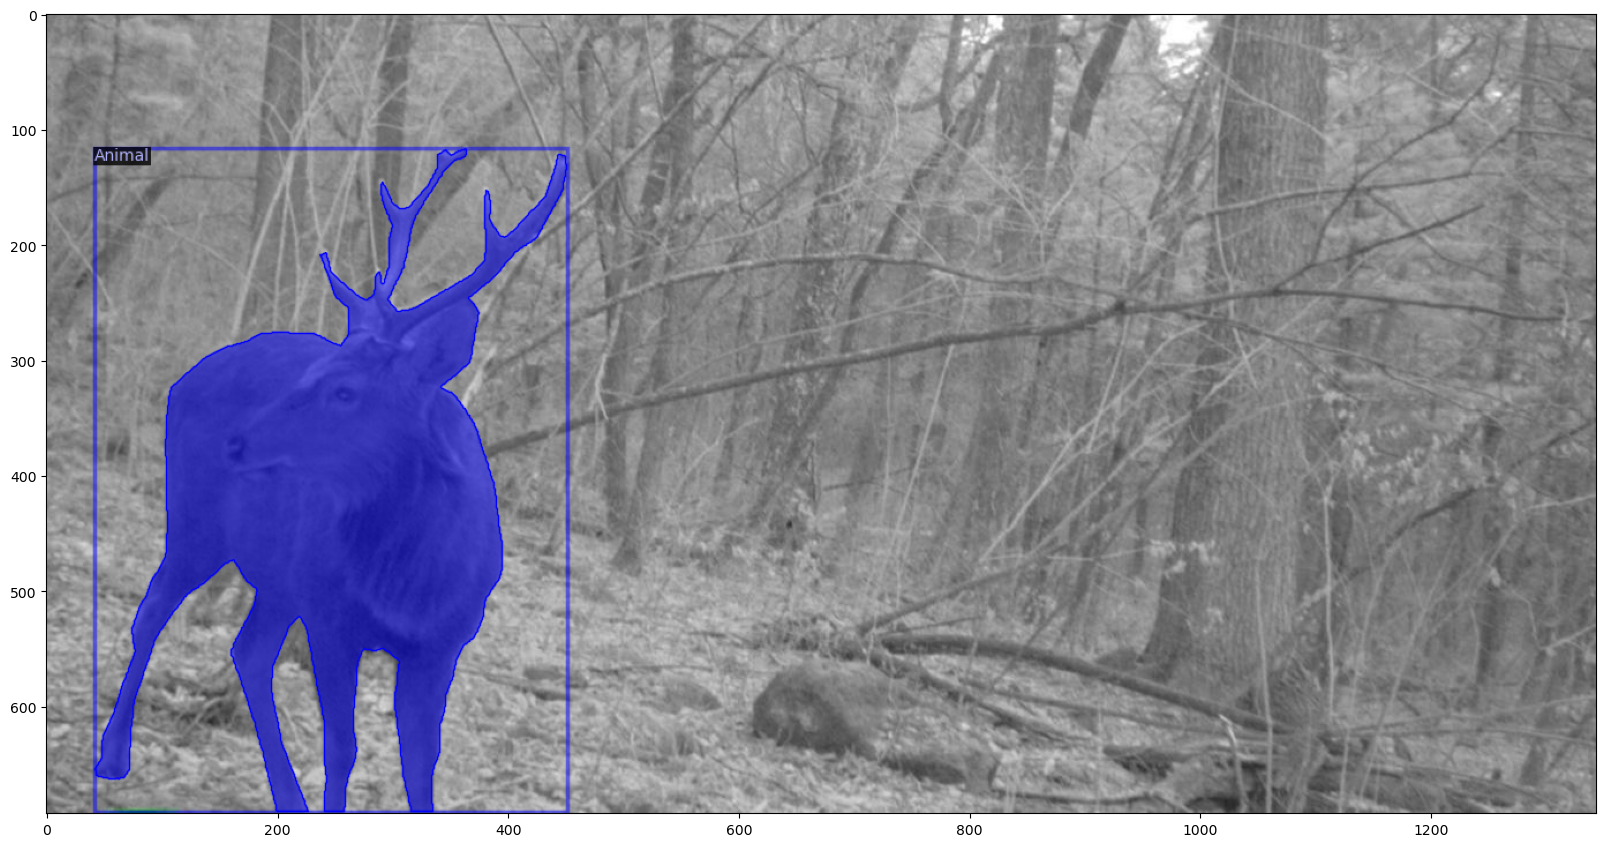

In [7]:
d = train_ds[8030]
img = cv2.imread(d["file_name"])
visualizer = Visualizer(img[:, :, ::-1], metadata=metadata)
out = visualizer.draw_dataset_dict(d)
plt.figure(figsize = (20,15))
plt.imshow(out.get_image()[:, :, ::-1])

### Define evaluator
Generates lines like this in the training output:
`[10/27 18:31:26 d2.evaluation.testing]: copypaste: MaP IoU=0.2192638391201311`

See here for definition: https://www.kaggle.com/c/sartorius-cell-instance-segmentation/overview/evaluation

In [8]:
from detectron2.evaluation import COCOEvaluator

cfg.OUTPUT_DIR = "output"

class Trainer(DefaultTrainer):
    @classmethod
    def build_train_loader(cls, cfg):
        return build_detection_train_loader(cfg,
                   mapper=DatasetMapper(cfg, is_train=True, augmentations=[
                        T.ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice'),
                   ]))

    @classmethod
    def build_evaluator(cls, cfg, dataset_name):
        return COCOEvaluator(dataset_name, tasks=("segm",), output_dir=cfg.OUTPUT_DIR)

### Train
I haven't done any hyperparameter optimization yet, this is mostly taken as is from the Detectron tutorial.

Training for 1000 iterations here for demonstration. For a high scoring model you will need to train it longer, closer to 10000 with these settings

In [9]:
from detectron2.engine import HookBase
from detectron2.evaluation import inference_on_dataset
from detectron2.data import build_detection_test_loader


class PeriodicAugmentor(HookBase):
    def __init__(self, dataset_names, annotation_files, output_annotation_files, img_dirs, output_dirs, transforms, period):
        self.dataset_names = dataset_names
        self.annotation_files = annotation_files
        self.output_annotation_files = output_annotation_files
        self.img_dirs = img_dirs
        self.output_dirs = output_dirs
        self.transforms = transforms
        self.period = period

    def after_step(self):
        if self.trainer.iter > 0 and self.trainer.iter % self.period == 0:
            self.augment()

    def augment(self):
        for i in range(len(self.annotation_files)):
            print(f"{Font.GREEN}Processing {self.annotation_files[i]} ...{Font.END}")

            coco = COCO(self.annotation_files[i])

            print(f"{Font.GREEN}Creating directory {self.output_dirs[i]} ...{Font.END}")

            os.makedirs(self.output_dirs[i], exist_ok=True)

            print(f"{Font.GREEN}Starting augmenting ...{Font.END}")

            for img_id in tqdm(coco.getImgIds()):
                file_name = coco.imgs[img_id]['file_name']
                anns_ids = coco.getAnnIds(img_id)

                masks = []
                for j in anns_ids:
                    masks.append(coco.annToMask(coco.anns[j]))

                image = cv2.imread(f'{self.img_dirs[i]}/{file_name}')
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

                transformed = self.transforms[i](image=image, masks=masks)

                plt.imsave(f'{self.output_dirs[i]}/{file_name}', transformed['image'])

                for n, anns_id in enumerate(anns_ids):
                    rle = maskUtils.encode(np.asfortranarray(transformed['masks'][n]))
                    bbox = list(maskUtils.toBbox(rle))
                    area = int(maskUtils.area(rle))

                    coco.anns[anns_id]['bbox'] = bbox
                    coco.anns[anns_id]['area'] = area
                    coco.anns[anns_id]['segmentation'] = {
                            "size" : rle["size"],
                            "counts" : rle["counts"].decode("utf-8")
                    }
                    
            # Update the dataset with the new annotations
            coco.dataset['annotations'] = list(coco.anns.values())

            print(f"{Font.GREEN}Writing to file {self.output_annotation_files[i]}...{Font.END}")

            # Save to a new JSON file
            with open(self.output_annotation_files[i], 'w') as f:
                json.dump(coco.dataset, f)
            
            DatasetCatalog.remove(self.dataset_names[i])
            MetadataCatalog.remove(self.dataset_names[i])
            register_coco_instances(self.dataset_names[i], {}, self.output_annotation_files[i], self.output_dirs[i])
            # self.trainer.train_loader = self.trainer.build_train_loader(self.trainer.cfg)

            print(f"{Font.GREEN}Done!{Font.END}")


class BestModelSaver(HookBase):
    def __init__(self, cfg, predictor, dataset_name, best_model_path, period):
        self.cfg = cfg
        self.predictor = predictor
        self.dataset_name = dataset_name
        self.best_model_path = best_model_path
        self.period = period
        self.best_res = 0

    def after_step(self):
        if self.trainer.iter > 0 and self.trainer.iter % self.period == 0:
            print(f"{Font.GREEN}Starting evaluation ...{Font.END}")
            res = self.eval()
            self.save(res)

    def eval(self):
        # self.cfg.MODEL.WEIGHTS = self.best_model_path
        # self.cfg.MODEL.ROI_HEADS.NUM_CLASSES = self.num_classes
        val_loader = build_detection_test_loader(self.cfg, self.dataset_name)
        # evaluator = self.trainer.build_evaluator(self.dataset_name, tasks=("segm",), output_dir=self.cfg.OUTPUT_DIR)
        evaluator = self.trainer.build_evaluator(self.cfg, self.dataset_name)
        return inference_on_dataset(self.predictor.model, val_loader, evaluator)
    
    def save(self, res):
        res = res['segm']['AP']
        if res > self.best_res:
            print(f"{Font.GREEN}Saving new best model with mAP: {res} ...{Font.END}")
            torch.save(self.trainer.model.state_dict(), self.best_model_path)
            self.best_res = res
        elif self.best_res == 0:
            print(f"{Font.GREEN}Saving last model weights ...{Font.END}")
            torch.save(self.trainer.model.state_dict(), self.best_model_path)

In [55]:
# from detectron2.evaluation import COCOEvaluator, inference_on_dataset
# from detectron2.data import build_detection_test_loader

# cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
# cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1
# predictor = DefaultPredictor(cfg)
# val_loader = build_detection_test_loader(cfg, "animal_val")
# evaluator = COCOEvaluator("animal_val", tasks=("segm",), output_dir=cfg.OUTPUT_DIR)
# res = inference_on_dataset(predictor.model, val_loader, evaluator)

In [56]:
# res['segm']['AP']

In [10]:
# cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml"))
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_X_101_32x8d_FPN_3x.yaml"))
# cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_X_101_32x8d_FPN_3x.yaml")  # Let training initialize from model zoo

cfg.DATASETS.TRAIN = ("animal_train",)
cfg.DATASETS.TEST = ("animal_val",)

cfg.DATALOADER.NUM_WORKERS = 2
cfg.SOLVER.IMS_PER_BATCH = 2

# epoch_size = round(len(train_ds) / cfg.SOLVER.IMS_PER_BATCH)
epoch_size = 500
epochs = 2
cfg.SOLVER.MAX_ITER = epoch_size * epochs
# cfg.SOLVER.MAX_ITER = 20
cfg.SOLVER.BASE_LR = 0.001
cfg.SOLVER.WEIGHT_DECAY = 0.0001
cfg.SOLVER.MOMENTUM = 0.9
cfg.SOLVER.GAMMA = 0.1
num_steps = epochs - 1
cfg.SOLVER.STEPS = [int(cfg.SOLVER.MAX_ITER / (num_steps + 1) * i) for i in range(1, num_steps + 1)]

cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TRAIN = 0.5
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5

# num_evals = 4
# cfg.TEST.EVAL_PERIOD = cfg.SOLVER.MAX_ITER // num_evals
cfg.TEST.EVAL_PERIOD = cfg.SOLVER.MAX_ITER + 1
# cfg.SOLVER.CHECKPOINT_PERIOD = 2000
cfg.SOLVER.CHECKPOINT_PERIOD = cfg.SOLVER.MAX_ITER + 1

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = Trainer(cfg)
predictor = DefaultPredictor(cfg)

best_model_path = os.path.join(cfg.OUTPUT_DIR, "best_model.pth")
torch.save(trainer.model.state_dict(), best_model_path)  # initialize best model save file

periodic_augmentor = PeriodicAugmentor(dataset_names=dataset_names, annotation_files=annotation_files, output_annotation_files=output_annotation_files,
                                       img_dirs=img_dirs, output_dirs=output_dirs, transforms=transforms, period=epoch_size - 1)
# best_model_saver = BestModelSaver(cfg=cfg, predictor=predictor, dataset_name=cfg.DATASETS.TEST[0],
#                                   best_model_path=best_model_path, period=epoch_size)
# trainer.register_hooks([periodic_augmentor, best_model_saver])
trainer.register_hooks([periodic_augmentor])

trainer.resume_or_load(resume=False)
trainer.train()

[01/30 19:37:28 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (2, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (2,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (1, 256, 1, 1) in

[01/30 19:37:31 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from https://dl.fbaipublicfiles.com/detectron2/COCO-InstanceSegmentation/mask_rcnn_X_101_32x8d_FPN_3x/139653917/model_final_2d9806.pkl ...
[Checkpointer] Loading from C:\Users\1003s/.torch/iopath_cache\detectron2/COCO-InstanceSegmentation/mask_rcnn_X_101_32x8d_FPN_3x/139653917\model_final_2d9806.pkl ...
Reading a file from 'Detectron2 Model Zoo'


Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (2, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (2,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (1, 256, 1, 1) in

[01/30 19:37:31 d2.engine.train_loop]: Starting training from iteration 0


c:\Users\1003s\anaconda3\envs\main\Lib\site-packages\torch\functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:3596.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[01/30 19:37:52 d2.utils.events]:  eta: 0:13:30  iter: 19  total_loss: 1.61  loss_cls: 0.7516  loss_box_reg: 0.1624  loss_mask: 0.6905  loss_rpn_cls: 0.0005905  loss_rpn_loc: 0.003036    time: 0.8368  last_time: 0.8221  data_time: 0.1679  last_data_time: 0.0015   lr: 2.881e-06  max_mem: 6707M
[01/30 19:38:08 d2.utils.events]:  eta: 0:13:12  iter: 39  total_loss: 1.554  loss_cls: 0.6806  loss_box_reg: 0.1549  loss_mask: 0.6829  loss_rpn_cls: 0.004204  loss_rpn_loc: 0.003657    time: 0.8309  last_time: 0.8232  data_time: 0.0015  last_data_time: 0.0016   lr: 4.861e-06  max_mem: 6728M
[01/30 19:38:25 d2.utils.events]:  eta: 0:12:54  iter: 59  total_loss: 1.352  loss_cls: 0.5492  loss_box_reg: 0.1268  loss_mask: 0.6648  loss_rpn_cls: 0.003915  loss_rpn_loc: 0.003557    time: 0.8282  last_time: 0.8272  data_time: 0.0014  last_data_time: 0.0013   lr: 6.841e-06  max_mem: 6728M
[01/30 19:38:41 d2.utils.events]:  eta: 0:12:37  iter: 79  total_loss: 1.245  loss_cls: 0.4257  loss_box_reg: 0.1272  

100%|██████████| 16631/16631 [12:45<00:00, 21.73it/s]


Writing to file augmented_train_annotations.json...
Done!
[01/30 19:57:33 d2.utils.events]:  eta: 0:06:37  iter: 519  total_loss: 0.8191  loss_cls: 0.08561  loss_box_reg: 0.1145  loss_mask: 0.4505  loss_rpn_cls: 0.04243  loss_rpn_loc: 0.008788    time: 0.8293  last_time: 0.8260  data_time: 0.0014  last_data_time: 0.0013   lr: 5.2381e-05  max_mem: 7068M
[01/30 19:57:49 d2.utils.events]:  eta: 0:06:21  iter: 539  total_loss: 0.8716  loss_cls: 0.07407  loss_box_reg: 0.1101  loss_mask: 0.4762  loss_rpn_cls: 0.02539  loss_rpn_loc: 0.006463    time: 0.8292  last_time: 0.8154  data_time: 0.0014  last_data_time: 0.0012   lr: 5.4361e-05  max_mem: 7068M
[01/30 19:58:06 d2.utils.events]:  eta: 0:06:04  iter: 559  total_loss: 0.7813  loss_cls: 0.07267  loss_box_reg: 0.1016  loss_mask: 0.4954  loss_rpn_cls: 0.04442  loss_rpn_loc: 0.008439    time: 0.8291  last_time: 0.8287  data_time: 0.0015  last_data_time: 0.0017   lr: 5.6341e-05  max_mem: 7068M
[01/30 19:58:23 d2.utils.events]:  eta: 0:05:48  it

 41%|████▏     | 6887/16631 [05:28<07:45, 20.95it/s]

[01/30 20:09:39 d2.engine.hooks]: Overall training speed: 996 iterations in 0:13:46 (0.8294 s / it)
[01/30 20:09:39 d2.engine.hooks]: Total training time: 0:32:02 (0:18:15 on hooks)
[01/30 20:09:39 d2.utils.events]:  eta: 0:00:00  iter: 998  total_loss: 0.7009  loss_cls: 0.06083  loss_box_reg: 0.09158  loss_mask: 0.5018  loss_rpn_cls: 0.01926  loss_rpn_loc: 0.007088    time: 0.8286  last_time: 0.8191  data_time: 0.0014  last_data_time: 0.0012   lr: 9.9802e-05  max_mem: 7068M


KeyboardInterrupt: 

In [120]:
# from pycocotools.coco import COCO
# from pycocotools.cocoeval import COCOeval

# cocoGt = COCO("updated_rle_val_annotations.json")
# # cocoDt = cocoGt.loadRes("output/coco_instances_results.json")
# cocoDt = cocoGt.loadRes("coco_instances.json")

loading annotations into memory...
Done (t=0.07s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.06s)
creating index...
index created!


In [121]:
# imgIds = cocoGt.getImgIds()
# cocoEval = COCOeval(cocoGt, cocoDt, "segm")
# cocoEval.params.imgIds = imgIds
# cocoEval.evaluate()
# cocoEval.accumulate()
# cocoEval.summarize()

Running per image evaluation...
Evaluate annotation type *segm*
DONE (t=1.50s).
Accumulating evaluation results...
DONE (t=0.37s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.774
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.938
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.904
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.038
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.419
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.807
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.749
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.810
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.810
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.033
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100

### Lets look at some of the validation files to check if things look reasonable
We show predictions on the left and ground truth on the right

[01/30 00:26:23 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from output\best_model.pth ...
[Checkpointer] Loading from output\best_model.pth ...


c:\Users\1003s\anaconda3\envs\main\Lib\site-packages\fvcore\common\checkpoint.py:252: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(f, map_location=torch.d

WARNING [01/30 00:26:23 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[01/30 00:26:23 d2.data.datasets.coco]: Loaded 8555 images in COCO format from updated_val_annotations.json


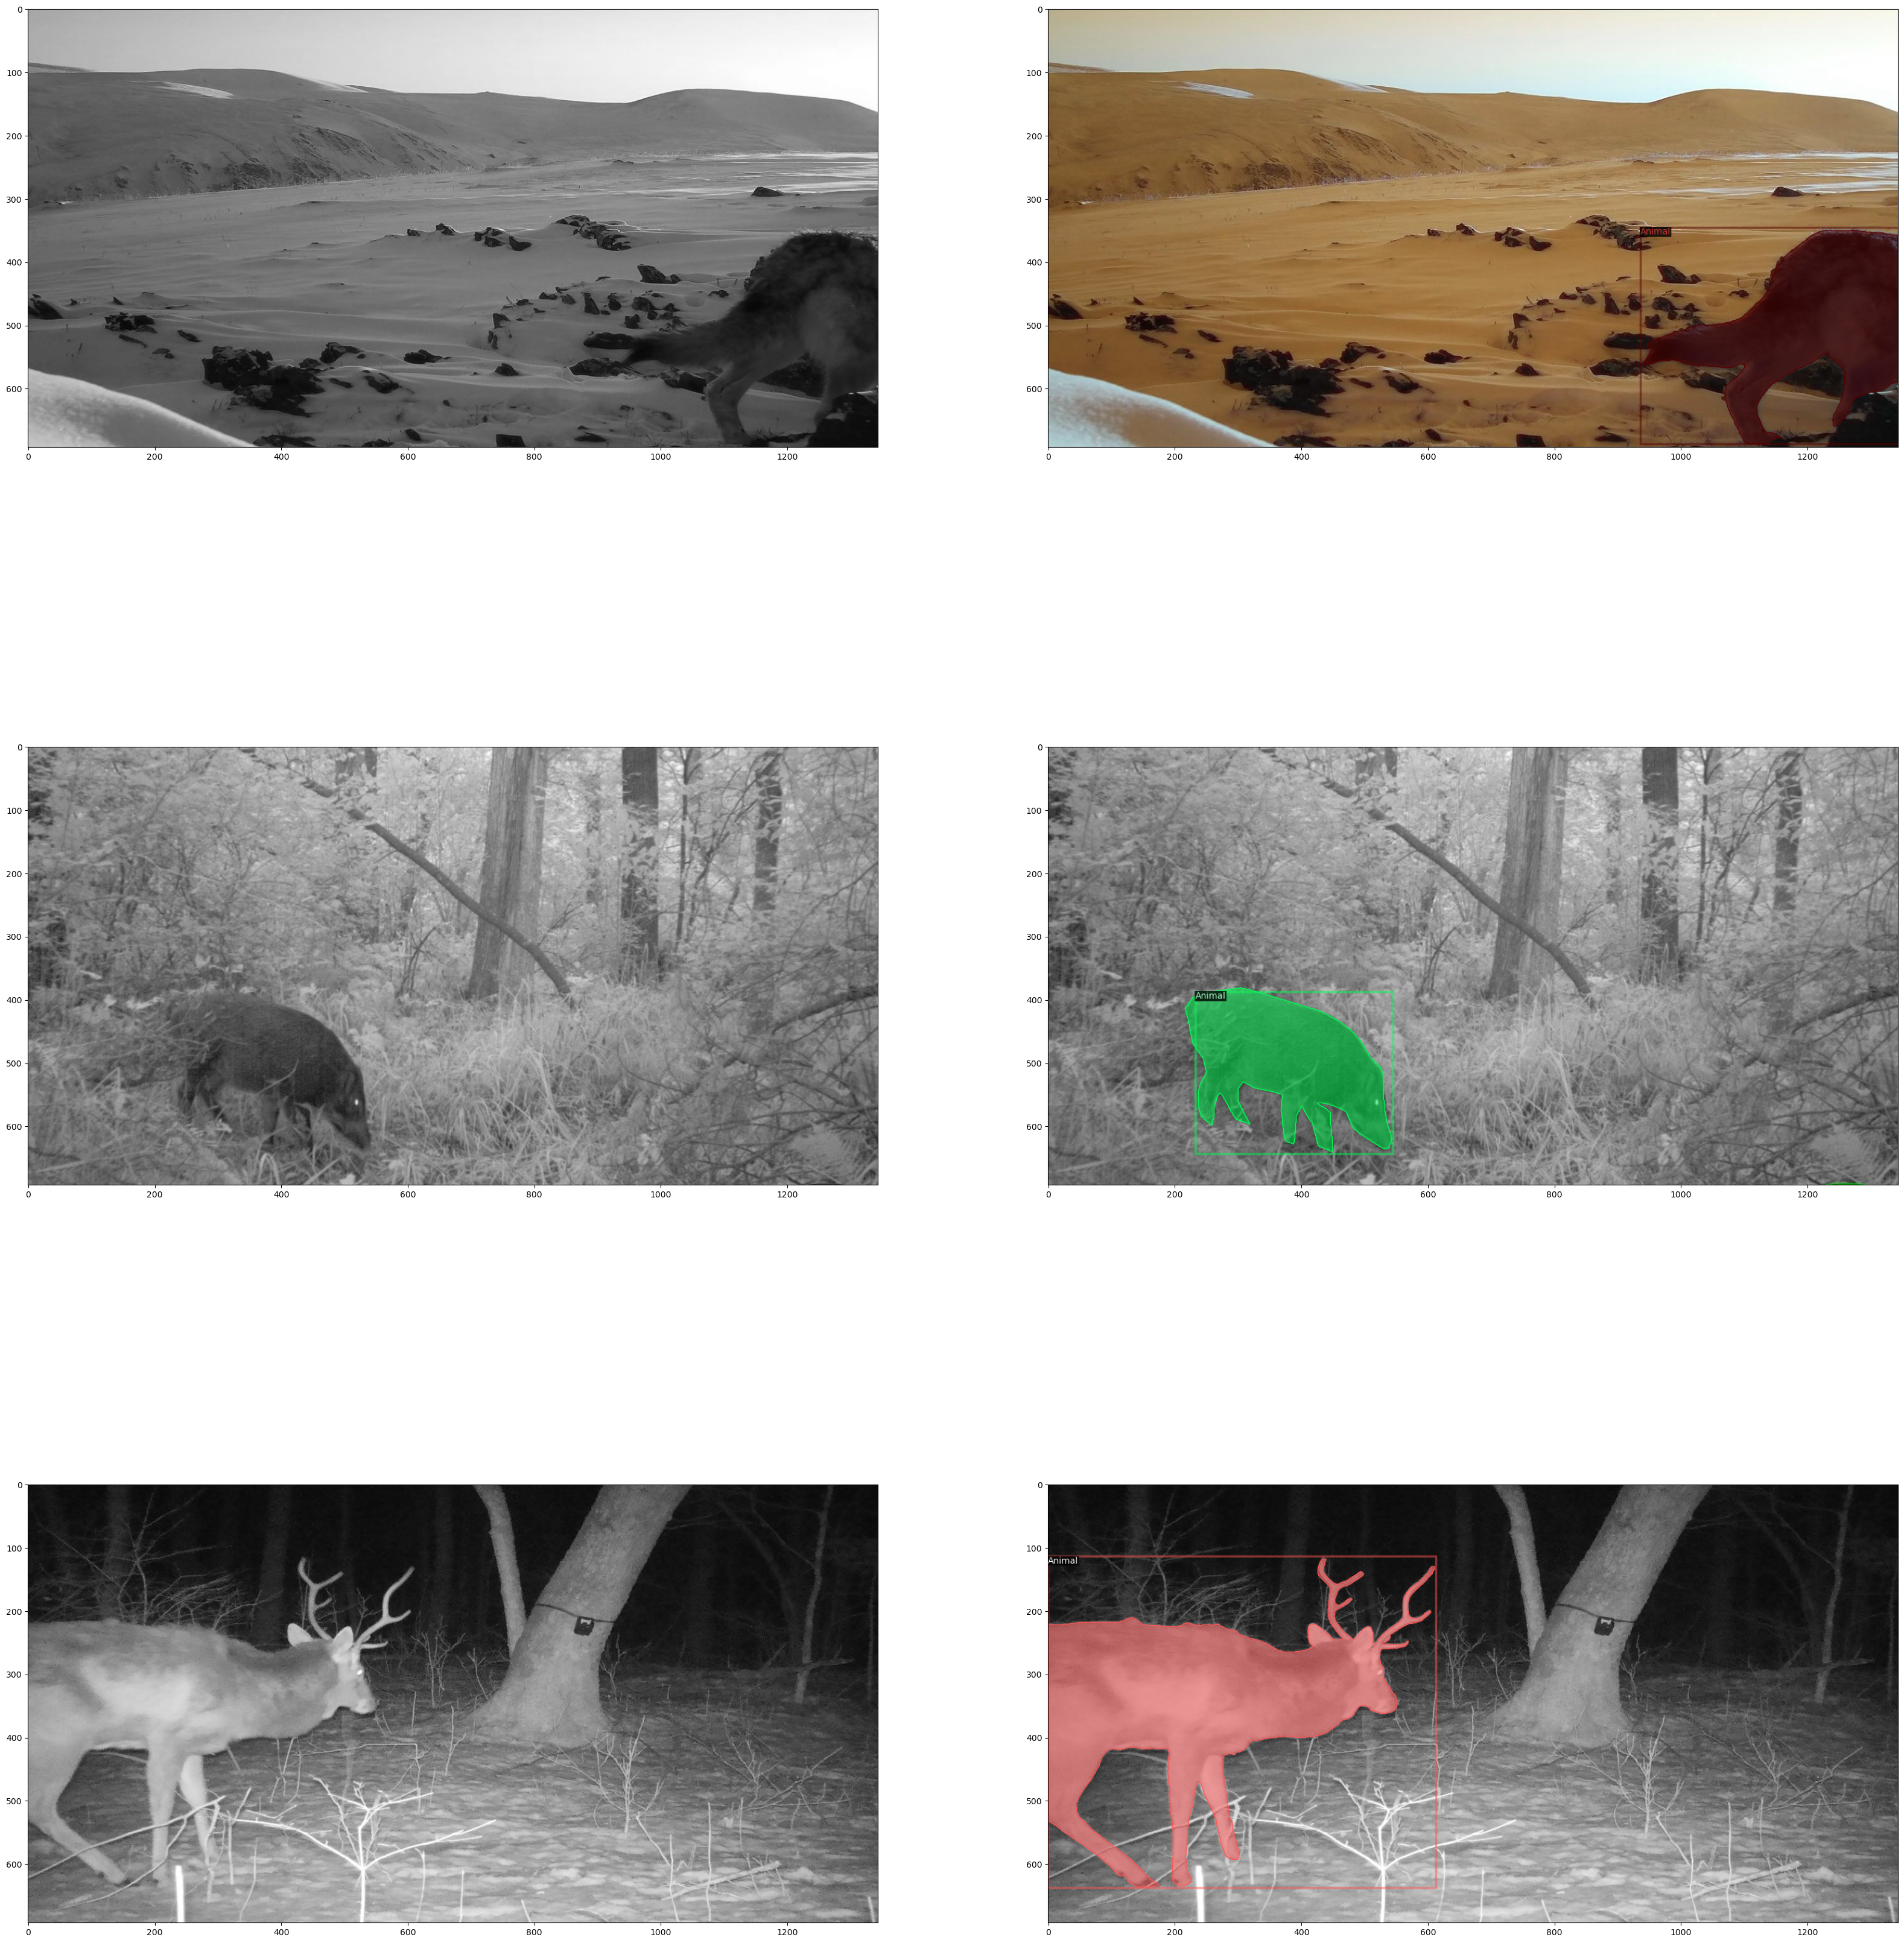

In [15]:
cfg.MODEL.WEIGHTS = best_model_path  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set a custom testing threshold
predictor = DefaultPredictor(cfg)
dataset_dicts = DatasetCatalog.get('animal_val')
outs = []
for d in random.sample(dataset_dicts, 3):
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    v = Visualizer(im[:, :, ::-1],
                   metadata = MetadataCatalog.get('animal_train'),

                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out_pred = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    visualizer = Visualizer(im[:, :, ::-1], metadata=MetadataCatalog.get('animal_train'))
    out_target = visualizer.draw_dataset_dict(d)
    outs.append(out_pred)
    outs.append(out_target)
_,axs = plt.subplots(len(outs)//2,2,figsize=(40,45))
for ax, out in zip(axs.reshape(-1), outs):
    ax.imshow(out.get_image()[:, :, ::-1])

### We can see that while it is not perfect, it did learn something
We can now take our model file and use it to generate submission in the [final notebook](https://www.kaggle.com/slawekbiel/positive-score-with-detectron-3-3-inference)

In [15]:
# !ls ./output/model_final.pth

"ls" �� ���� ����७��� ��� ���譥�
��������, �ᯮ��塞�� �ணࠬ��� ��� ������ 䠩���.


In [13]:
from tqdm import tqdm
import pycocotools
import json

# Папка с тестовыми изображениями
cfg.MODEL.WEIGHTS = best_model_path
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
predictor = DefaultPredictor(cfg)

test_folder = "test"
output_folder = "output"  # Папка для сохранения результатов
os.makedirs(output_folder, exist_ok=True)

# Список для хранения предсказаний в нужном формате
predictions = []

# Обработка изображений
for file_name in tqdm(os.listdir(test_folder)):
    image_path = os.path.join(test_folder, file_name)
    image = cv2.imread(image_path)

    # Выполнение предсказания
    outputs = predictor(image)

    # Получаем сегментацию и другие данные
    instances = outputs["instances"].to("cpu")
    # print(instances)
    pred_classes = instances.pred_classes.tolist()  # Классы объектов
    pred_boxes = instances.pred_boxes.tensor.tolist()  # Координаты bbox
    pred_scores = instances.scores.tolist()  # Скоринг предсказаний
    pred_segmentation = instances.pred_masks.tolist()  # Сегментация

    # Сохраняем предсказания для каждого объекта в изображении
    for i in range(len(pred_classes)):
        # pred_segmentation = instances.pred_masks.tolist()
        rle = pycocotools.mask.encode(np.asfortranarray(pred_segmentation[i]))
        predictions.append({
            "image_name": file_name,
            "category_id": pred_classes[i],  # ID категории
            "bbox": pred_boxes[i],  # Координаты bounding box
            "score": pred_scores[i],  # Оценка уверенности
            "segmentation": {
                "size" : rle["size"],
                "counts" : str(rle["counts"])
            }  # Сегментация в формате RLE
        })


# Сохранение предсказаний в JSON
predictions_file = os.path.join(output_folder, "submission.json")
with open(predictions_file, "w") as f:
    json.dump(predictions, f, indent=4)

print(f"Обработка завершена. Результаты сохранены в папке: {output_folder}")


[01/26 16:27:58 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output\model_final.pth ...
[Checkpointer] Loading from ./output\model_final.pth ...


c:\Users\1003s\anaconda3\envs\main\Lib\site-packages\fvcore\common\checkpoint.py:252: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(f, map_location=torch.d

Обработка завершена. Результаты сохранены в папке: output
